In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample()

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierBottomUp.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierBottomUpMAB.py', '../models/SmartVariationSimplifyMAB.py', '../models/SimplifierBottomUpCMAB.py', '../models/SmartVariationMAB.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SmartVariationSimplify.py', '../models/SimplifierTopDownOnlyLast.py', '../models/SmartVariation.py'] ['Bottom Up', 'Bottom Up (only last)', 'Bottom Up MAB', 'LSH Variator with simplify and MAB', 'Bottom Up cMAB', 'LSH Variator with MAB', 'Top Down', 'Without simplify', 'LSH Variator with simplify', 'Top Down (only last)', 'LSH Variator']
(71, 14)
['Without simplify' 'LSH Variator']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating']
[15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 150]


In [2]:
all_data = []
for i, row in results_df.iterrows():
    model, dataset, random_state = row.loc[['model', 'dataset', 'random_state']]

    files = glob(f"{results_path}/{dnames_to_ugly[dataset]}/{nice_to_ugly[model]}/"
                f"*{random_state}_evolution.csv")

    for file in files:
        data = pd.read_csv(file)
        
        for gen in gens:
            try:
                row = data[data['gen']==gen].iloc[0] # should have just 1 row
            except Exception as e:
                print(e)
                # print(file, gen)
                # print(row)
                continue
            
            all_data.append((model, dataset, *row))
            
all_data_df = pd.DataFrame(all_data, 
                           columns=(
                               'model',
                               'dataset',
                               *row.index
                           ))

all_data_df = all_data_df.replace([np.inf, -np.inf], np.nan).dropna()

print(all_data_df.shape)
print(all_data_df['model'].unique())
print(all_data_df['dataset'].unique())
all_data_df.sample(5)

(1042, 27)
['Without simplify' 'LSH Variator']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating']


,model,dataset,gen,evals,best_size,n_simplifications,n_new_hashes,avg train error,avg train size,avg val error,...,std val error,std val size,min train error,min train size,min val error,min val size,max train error,max train size,max val error,max val size
1055,LSH Variator,Energy Heating,65.0,80.0,24.0,0.0,0.0,5.660106,24.0000,7.368074,...,0.000000,0.000000,5.660106,24.0,7.368074,24.0,5.660106,24.0,7.368074,24.0
735,Without simplify,Energy Cooling,15.0,80.0,9.0,0.0,0.0,16.353354,7.4000,18.727032,...,4.204280,2.130728,13.693393,4.0,16.282120,4.0,43.363269,11.0,46.436512,11.0
72,Without simplify,Airfoil,135.0,80.0,49.0,0.0,0.0,15.021875,49.7375,17.106938,...,3.270981,0.607119,14.624464,48.0,16.695953,48.0,45.553017,51.0,46.179802,51.0
879,LSH Variator,Energy Cooling,105.0,80.0,35.0,0.0,0.0,4.456231,34.9875,4.493325,...,0.012902,0.111102,4.455702,34.0,4.446163,34.0,4.476098,35.0,4.506215,35.0
259,LSH Variator,Airfoil,55.0,80.0,25.0,0.0,0.0,20.984942,26.3500,17.790239,...,0.385323,1.659066,20.856455,22.0,17.258574,22.0,21.251074,31.0,18.185751,31.0


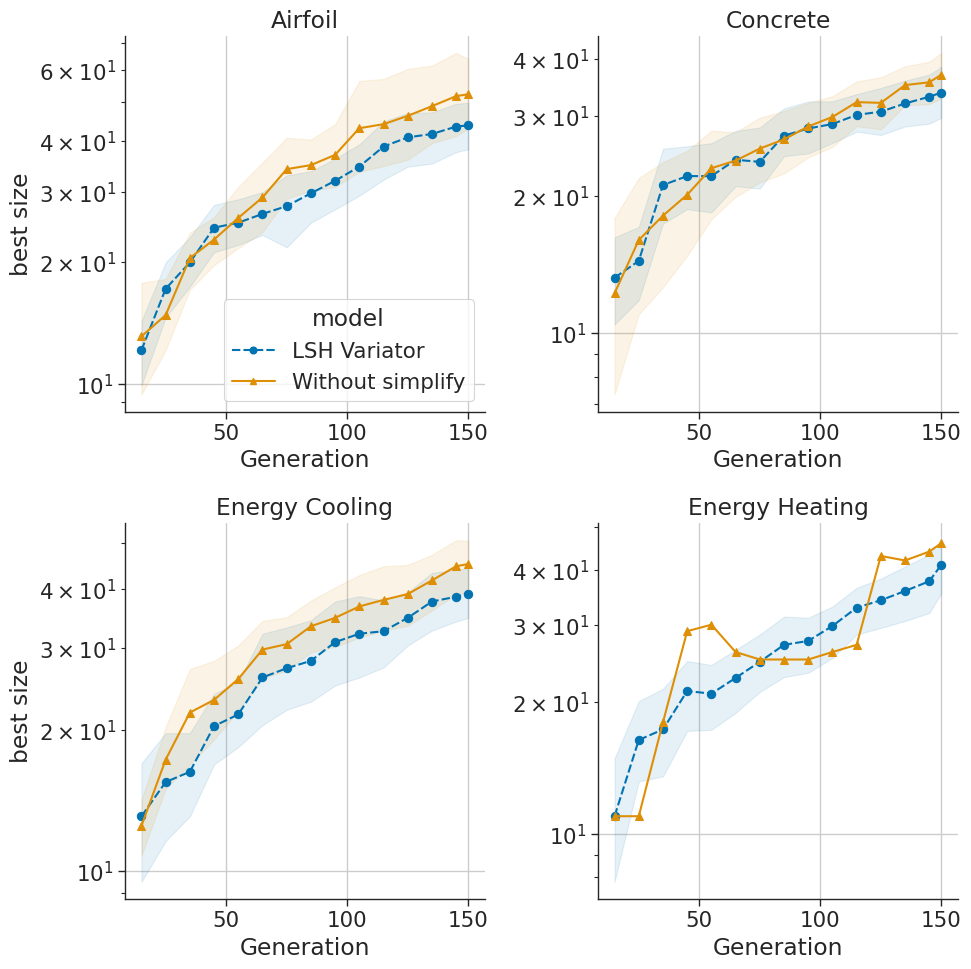

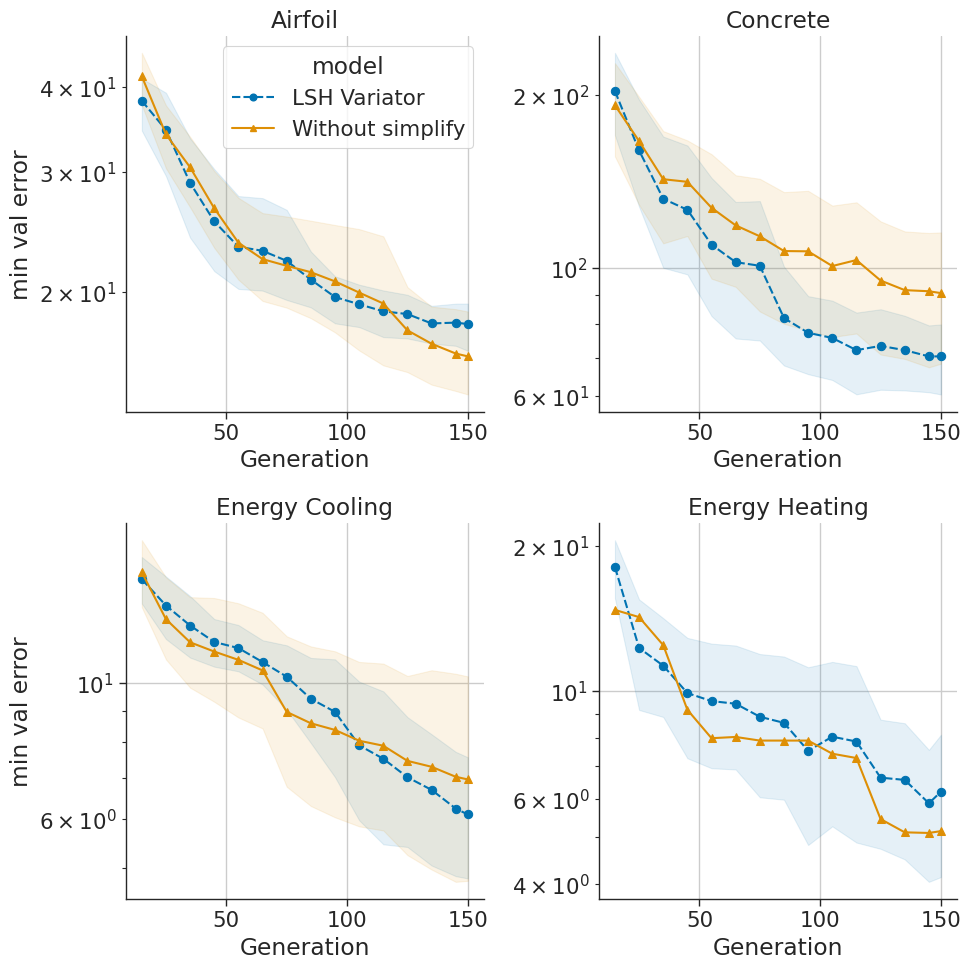

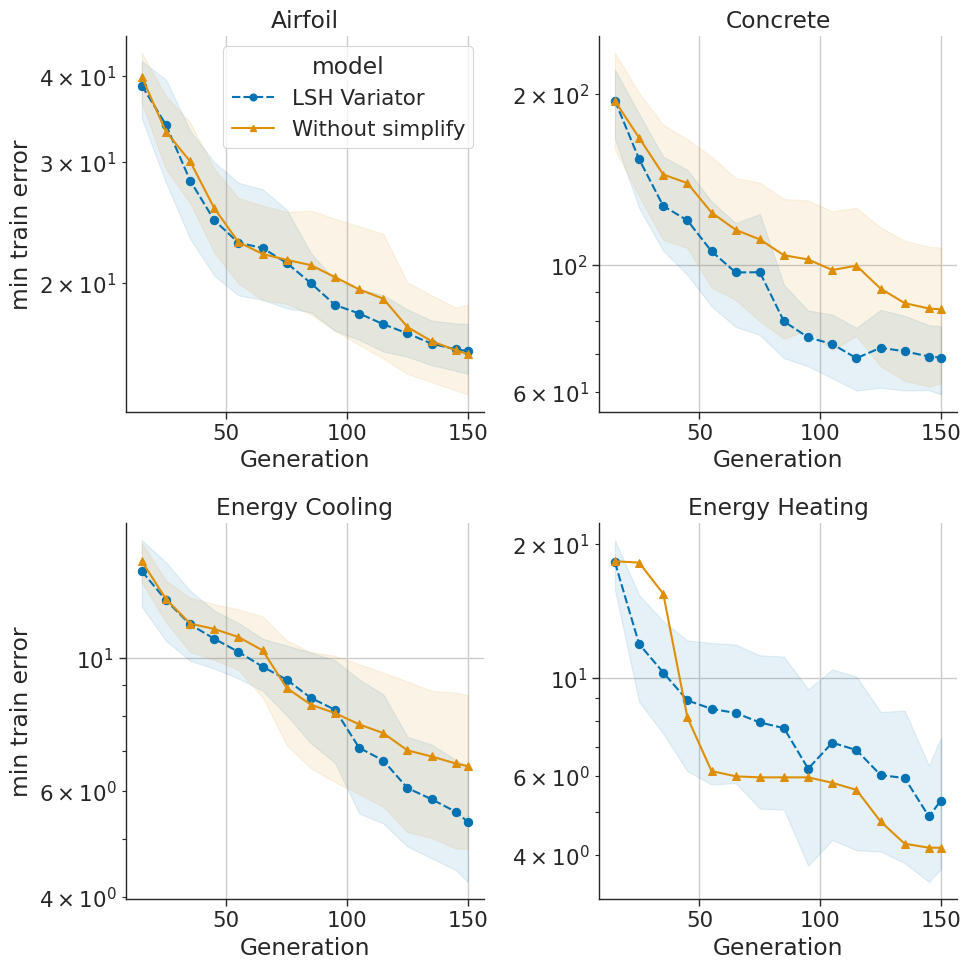

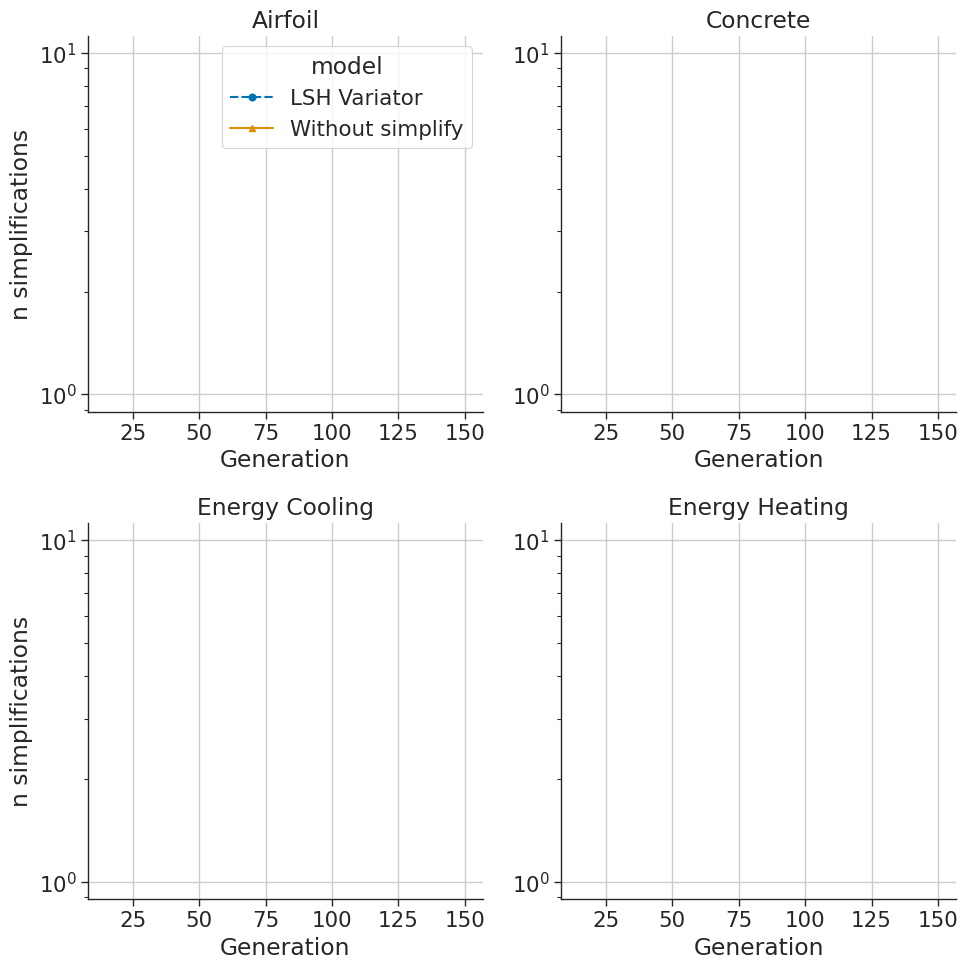

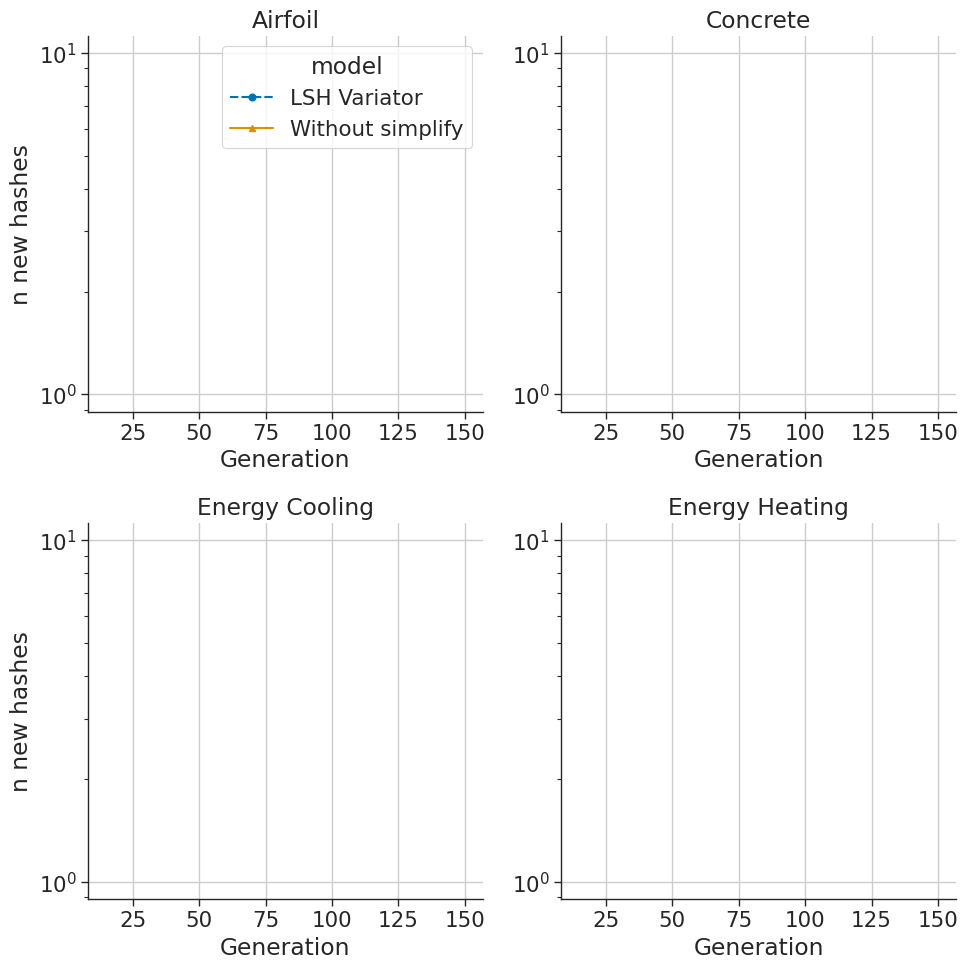

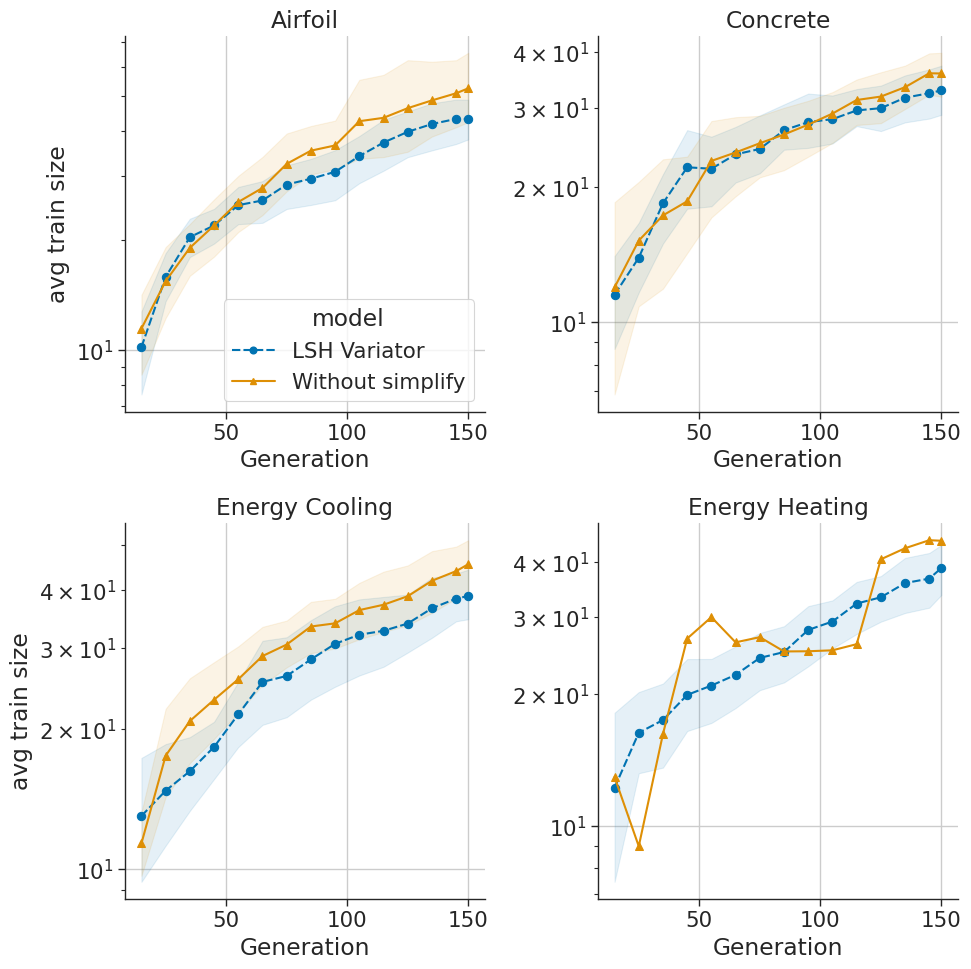

In [3]:
for col in [
    'best_size','min val error', 'min train error',
    'n_simplifications', 'n_new_hashes','avg train size',
    #'med train error','med val error',
]:
    
    # about errors: https://seaborn.pydata.org/tutorial/error_bars.html
    g = sns.relplot(
        data=all_data_df,
        x="gen", y=col, col="dataset", hue="model",
        style="model", col_wrap=col_wrap, markers=marker_choice, markeredgecolor=None, 
        kind="line", facet_kws={'sharey': False, 'sharex': False, 'legend_out':False}, 
        hue_order = order, estimator=np.mean, markersize=6,
        
        #err_style='bars', err_kws={'capsize':0.0, 'linewidth':0.0},
        #err_style='bars', err_kws={'capsize':2.0, 'linewidth':0.5}, # 2.0, 0.5
        err_style='band', err_kws={'alpha':0.1},
    )
    g.set_titles("{col_name}")

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='both', linewidth=1)
        plot_ax.set_xlabel("Generation")
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('_', ' '))

    if True: # use log scale
        #g.set(xscale="log")
        g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{col}.pdf")
    plt.savefig(f"../paper/figs/{col}.png")
    plt.show()